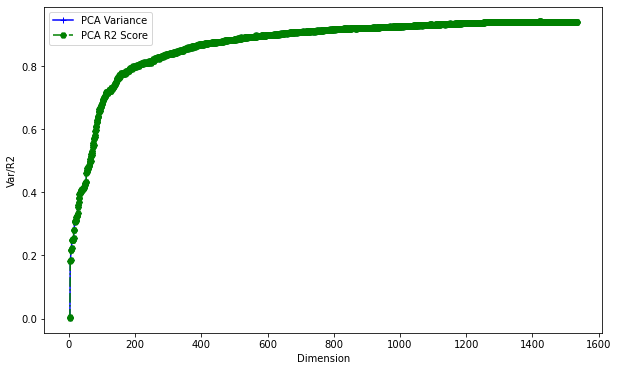

In [5]:
import requests
import json
import pandas as pd
import seaborn
import warnings
import numpy as np
import operator
import sys
import matplotlib.pyplot as plt

from pandas.io.json import json_normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from sklearn import linear_model
from sklearn.metrics import make_scorer,mean_squared_error,r2_score,mean_absolute_error,accuracy_score, confusion_matrix
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, RandomForestClassifier, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.datasets import make_classification
from sklearn import svm, tree
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier


def pca(i, X_train, X_test, Y_train, Y_test, dev=False):
  '''
  Perform PCA on either train/validation set or on test set
  @params:
      i: number of components
      X_train, X_test, Y_train, Y_test: testing/training lists
      dev: set to true if doing validation testing; false if using test set data      
  '''

  pca = PCA(n_components=i)
  X_train = pca.fit_transform(X_train)
  X_test=pca.transform(X_test)
  model = LinearRegression()

  if dev == True:
    train_pca, dev_pca, train_labels_pca, dev_labels_pca = train_test_split(X_train, Y_train, test_size=0.33, random_state=42)
    model.fit(train_pca, train_labels_pca)
    res_sum_square= np.mean((model.predict(dev_pca) - dev_labels_pca ** 2))
    var_val=model.score(dev_pca, dev_labels_pca)
    Y_test_predict = model.predict(dev_pca)
    r2_val=r2_score(dev_labels_pca,Y_test_predict)
    return model.intercept_,model.coef_,res_sum_square,var_val,r2_val

  else:
    model.fit(X_train, Y_train)
    res_sum_square= np.mean((model.predict(X_test) - Y_test ** 2))
    var_val=model.score(X_test, Y_test)
    Y_test_predict = model.predict(X_test)
    r2_val=r2_score(Y_test,Y_test_predict)
    return var_val,r2_val


def plot_dim_comp(variance, r2):
  '''
  Plot the change in variance/r2 accross different dimensions
  @params:
      variance: list of variance scores
      r2: list of r2 scores
  '''
  plt.figure(figsize=(10,6))
  plt.plot(num_of_comp, variance, label = 'PCA Variance', linestyle = '-', marker = '+', color = 'b')
  plt.plot(num_of_comp, r2, label = 'PCA R2 Score', linestyle = '-.', marker = 'H', color = 'g')
  plt.xlabel('Dimension')
  plt.ylabel('Var/R2')
  plt.legend()
  plt.show()


### Preprocessing ###


df = pd.read_csv('C:\\Users\\Kurly\\Downloads\\Universal-Embeddings-testing\\Universal-Embeddings-Nick\\data\\all_data_clean.csv')

columns = list(df.columns.values)

# Features list and removal of city, lat, lon
features = list(df.columns.values)
del features[:3]
del features[-1]

# y value list using last day of 7-month data
y = df.loc[:, ['nh3_2021_06_06']].values

# Normalize x values
x = df.loc[:, features].values
x = Normalizer().fit_transform(x)

# Number of features to compare
num_of_comp=inp=list(range(2,1535))


### Cross Validation ### 


# k-fold cross validation; any cross-validation technique can be substituted here
kfold = KFold(n_splits=5, shuffle=True)
count=0
# Train/test and metrics for current component's set of data
train_test_dict = {}
metrics={}
# Contains all train_test splits/metrics in PCA for n components and 
# m sets of splits
train_test_comp = {}
metrics_comp = {}
metrics_comp_set = {}

# Loop through train/test data and save the best data with highest R2 scores
for training_index, test_index in kfold.split(x):
  # Split X and Y train and test data
  X_train, X_test = x[training_index, :], x[test_index, :]
  Y_train, Y_test = y[training_index], y[test_index]
  count+=1

  # Update dict with train/test values
  train_test_dict['X_train'] = X_train
  train_test_dict['X_test'] = X_test
  train_test_dict['Y_train'] = Y_train
  train_test_dict['Y_test'] = Y_test

  # Save best sets of train/test data that have high R2 scores
  train_test_comp[count] = train_test_dict.copy()
  
  # Create and save a list of metrics 
  for i in num_of_comp:
    model_intercept, model_coef, res_sum_square, variance_score, Rsquare = pca(i, X_train, X_test, Y_train, Y_test, dev=True)
    # Create metrics list for current comparison
    metrics['model_intercept']=model_intercept
    metrics['model_coef']=model_coef
    metrics['res_sum_square']=res_sum_square
    metrics['variance_score']=variance_score
    metrics['Rsquare']=Rsquare
    metrics_comp[i] = metrics.copy()
  # Save each metrics comparison for later
  metrics_comp_set[count] = metrics_comp.copy()


### Calculate the R2 score for each component ###


best_r2 = -100
sets = 0
for i in metrics_comp_set:
  for j in metrics_comp_set[i]:
    R2 = metrics_comp_set[i][j]['Rsquare']
    #print('set : ' + str(i) + ' ' + 'comp' + ' ' + 
    #    str(j) + ' ' + 'Rsquare' + ' ' + str(R2))
    if R2 >= best_r2:
      best_r2 = R2
      sets=i

# Graph PCA to test set with best components
# using the best set to call PCA function to use the test set with all components
pca_r2=[]
pca_variance=[]

# Obtain optimal PCA variance and R2 scores and add to list
for i in train_test_comp:
  if i == sets:
    for j in train_test_comp[sets]:
      if 'X_test'==j:
        X_ttbest=train_test_comp[sets][j]
      elif 'X_train' ==j:
        X_tnbest=train_test_comp[sets][j]
      elif 'Y_test' ==j:
        Y_ttbest=train_test_comp[sets][j]
      elif 'Y_train'==j:
        Y_tnbest=train_test_comp[sets][j]
for i in num_of_comp:   
    variance,R2 = pca(i, X_tnbest, X_ttbest, Y_tnbest ,Y_ttbest, dev=False)
    pca_variance.append(variance)
    pca_r2.append(R2)
#print(bestR2PCA)
#print(bestvarPCA)

# Plot the variance/r2 across dimensions
plot_dim_comp(variance=pca_variance, r2=pca_r2)



